## Load package and seth path

In [1]:
%matplotlib inline

import os,sys
import pandas as pd
import numpy as np
import geopandas as gpd
import rasterio
#!pip install geopy
#!pip install boltons
from pathlib import Path
from geofeather.pygeos import to_geofeather, from_geofeather
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from rasterio.plot import show
from IPython.display import display #when printing geodataframes, put it in columns -> use display(df)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, LinearLocator, MaxNLocator)
import pygeos
from pgpkg import Geopackage
import matplotlib.pyplot as plt
import copy

sys.path.append("C:\Projects\gmhcira\scripts")
import functions

plt.rcParams['figure.figsize'] = [20, 20]

from osgeo import gdal
gdal.SetConfigOption("OSM_CONFIG_FILE", os.path.join("..","osmconf.ini"))



### Set pathways

In [2]:
base_path = os.path.abspath('C:/Users/snn490/surfdrive/Outputs/Exposure/health_polygons') #this path contains all data that's needed as input and will contain directories to export outputs

# Set path to inputdata
osm_data_path = os.path.abspath(os.path.join('C:/Users/snn490/surfdrive/Datasets/OpenStreetMap')) #path to map with infra-gpkg's 

# path to save outputs - automatically made, not necessary to change output pathways
output_infra_path = os.path.abspath(os.path.join(base_path, 'extract')) #save interim calculations

# path to our python scripts
sys.path.append(os.path.join('..','scripts'))

#Create folders for outputs (GPKGs and pngs)
Path(output_infra_path).mkdir(parents=True, exist_ok=True)

## Check power data

In [8]:
check = from_geofeather(os.path.join(r'\\labsdfs.labs.vu.nl\labsdfs\BETA-IVM-BAZIS\snn490\Outputs\Exposure\receipt\power\Fetched_infrastructure', 'DEU_power.feather'))

In [7]:
check['asset'].value_counts()

power_pole     713209
power_tower    210146
minor_line      61437
substation      37728
line            31132
cable            4695
plant            1749
Name: asset, dtype: int64

In [8]:
1749 - 1354

395

In [9]:
37728 - 34921

2807

## Process airports

In [3]:
#pathways 
base_path = os.path.abspath(r'\\labsdfs.labs.vu.nl\labsdfs\BETA-IVM-BAZIS\snn490\Outputs\gmhcira\Fetched_infrastructure')

areas = ['DEU','ITA','FRA']

airport_dict = {}

for area in areas:
    df = from_geofeather(os.path.join(base_path, '{}_airports.feather'.format(area)))
    print("For {} show the extracted infrastructure types: \n{}".format(area, df['asset'].value_counts()))
    
    # make seperate df with aerodromes
    df_adjust = df[df['asset'] == 'aerodrome'].reset_index(drop=True) 
    df_adjust = df_adjust.drop(columns=['osm_id','asset']).rename(columns={'geometry':'aerodrome_geometry'})

    # calculate area of aerodromes
    df_adjust['aerodrome_m2']=functions.polygon_area_pygeos(list(df_adjust.aerodrome_geometry)) #calculate area per object and put in dataframe

    #double check aerdromes to make sure they don't overlap - necessary?
    #add terminal and runways columns for geometries and areas/lengths to adjusted df
    #df_adjust['terminal_geometry'] = np.nan
    #df_adjust['terminal_m2'] = ""
    #df_adjust['runway_geometry'] = np.nan
    #df_adjust['runway_m'] = ""

    #loop through original df, and see if infrastructure type falls within aerodrome. If so, create new column and add amount of infrastructure type in area or lengths
    lst_infrastructure_types = ['terminal','runway']
    airport_dict[area]=functions.estimate_infra_in_aerodrome(lst_infrastructure_types, df, df_adjust)


For DEU show the extracted infrastructure types: 
helipad                     1256
runway                      1246
apron                       1067
hangar                       987
aerodrome                    661
terminal                     215
taxiway                      109
tower                         40
navigationaid                 26
signal_area                   22
heliport                      19
deicing                       14
jet_bridge                    13
airstrip                      12
fuel                          10
gate                           8
control_tower                  6
yes                            5
preserved                      5
construction                   4
control_center                 4
proposed                       4
model                          3
model_aerodrome                3
parking_position               2
dropzone                       2
model_runway                   2
marking                        2
landing_strip             

In [41]:
#calculate proportions
for area in areas:
    airport_dict[area]['%terminal'] = airport_dict[area]['terminal_m2']/airport_dict[area]['aerodrome_m2']*100
    airport_dict[area]['%runway'] = airport_dict[area]['runway_m']/airport_dict[area]['aerodrome_m2']*100

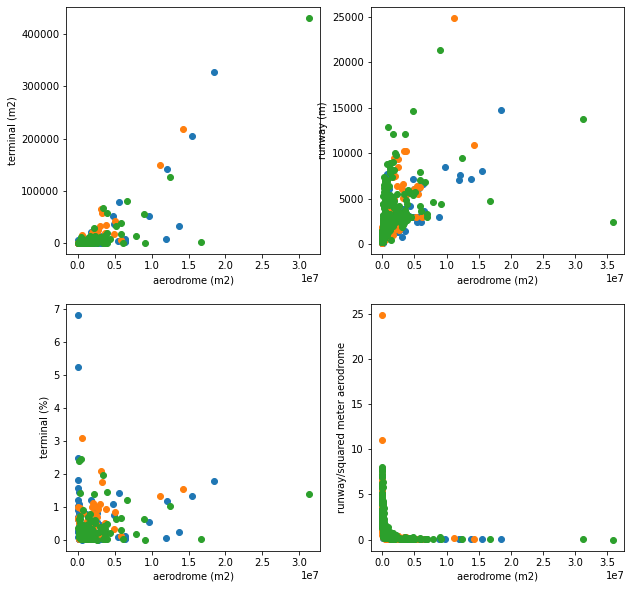

In [42]:
# make graphs
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
#fig.suptitle('Horizontally stacked subplots')

#aerodrome vs terminal size
for area in areas:
    ax1.plot(airport_dict[area]['aerodrome_m2'], airport_dict[area]['terminal_m2'], 'o')
    ax1.set_xlabel('aerodrome (m2)')
    ax1.set_ylabel('terminal (m2)')
    #ax1.set_title('aerodrome vs terminal size')

#aerodrome vs runway 
for area in areas:
    ax2.plot(airport_dict[area]['aerodrome_m2'], airport_dict[area]['runway_m'], 'o')
    ax2.set_xlabel('aerodrome (m2)')
    ax2.set_ylabel('runway (m)')
    #ax2.set_title('aerodrome vs runway ')
    
#aerodrome vs terminal size proportional
for area in areas:
    ax3.plot(airport_dict[area]['aerodrome_m2'], airport_dict[area]['%terminal'], 'o')
    ax3.set_xlabel('aerodrome (m2)')
    ax3.set_ylabel('terminal (%)')
    #ax3.set_title('aerodrome vs terminal size')

#aerodrome vs runway proportional
for area in areas:
    ax4.plot(airport_dict[area]['aerodrome_m2'], airport_dict[area]['%runway'], 'o')
    ax4.set_xlabel('aerodrome (m2)')
    ax4.set_ylabel('runway/squared meter aerodrome')
    #ax4.set_title('aerodrome vs runway ')



### filter OSM data with Openflights data

In [ ]:
#pathway to open flight database for airports
#pathway to OSM data

# set variables
# areas 

In [ ]:
openflight_df = pd.read_excel(os.path.join(infra_base_path, 'summary_base_{}.xlsx'.format(ci_system)), sheet_name="Sheet1")
openflight_df = summary_df.set_index('Airport ID')